# Descriptive stats
This experiment describes the used datasets in terms of the evaluation as the uncontrolled ground truth.

In [33]:
import sys
sys.path.append(f'../source')
import data
import helpers
import importlib
importlib.reload(data)
import evaluation
import models
import numpy as np
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import DataParallel
import random
from matplotlib import pyplot as plt
import pickle
import os
from dotenv import load_dotenv
load_dotenv()
random.seed(os.getenv("RANDOM_SEED"))

[nltk_data] Downloading package punkt to
[nltk_data]     /cluster/scratch/dglandorf/cache...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# params
out_file = '../data/corpus_classification.pkl'
dir="corpus_training"
max_responses = int(1e4)
n = 4
batch_size = 256

Load dialogs and list of classifiers

In [31]:
dialog_data = data.get_dialog_data()
random.shuffle(dialog_data)
classifiers_nrs = helpers.get_existing_classifiers(dir)
egp = helpers.get_egp()

12460
12460
12460
25578
25578
25578
44008
44008
44008
48229
48229
48229
56857
56857
56857


Preprocess data

In [101]:
extracts = [[(dialog[0][i-n:i], dialog[0][i], dialog[1]) for i in range(n, len(dialog[0]))] for dialog in dialog_data]
extracts = helpers.flatten_list_of_lists(extracts)
extracts = extracts[0:max_responses]
sentences = [(idx, sentence) for idx, (context, response, source) in tqdm(enumerate(extracts), total=len(extracts)) for sentence in data.sent_tokenize(response)]
indices, sents = [s[0] for s in sentences], [s[1] for s in sentences]

  0%|          | 0/10000 [00:00<?, ?it/s]

## Run on corpus

In [102]:
encoded_inputs = models.bert_tokenizer(sents, return_tensors='pt', max_length=64, padding='max_length', truncation=True)
corpus_dataset = TensorDataset(encoded_inputs['input_ids'], encoded_inputs['attention_mask'])
corpus_dataloader = DataLoader(corpus_dataset, batch_size=batch_size, shuffle=False)

In [103]:
all_hit_indices = {}
all_hit_sentences = {}
for nr in classifiers_nrs:
    print(egp.iloc[nr-1]['Can-do statement'])
    classifier = models.load_classifier(nr, dir)
    classifier = DataParallel(classifier)
    scores, tokens = models.score_corpus(classifier, corpus_dataloader, max_positive=1e10, max_batches=1e5, threshold=0.5)
    results = list(zip(scores, sents))
    
    hit_indices = np.array(indices)[np.array(scores)>0.5]
    print("{:.2f}%".format(len(np.unique(hit_indices))/len(extracts)*100))
    
    hit_sentences = [sample for score, sample in results if score > 0.5]
    print(hit_sentences[0:10])
    
    all_hit_indices[nr] = hit_indices
    all_hit_sentences[nr] = hit_sentences

Can use the affirmative form with 'like'. 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.39it/s]


0.85%
["I've been wearing my hair long for years, but now I'd like to try some kind of modern style.", "We'd like to wash your hair first.", "I'd like to check that out.", "I've tried playing the piano but admittedly I am not that great, I would like to learn someday though!", 'I wonder if I would like it again or if it would be lame', 'Any other information you would like to share?', 'Yeah I would like to see a fight settled between the two, that would be hilarious!', 'I think I would like the boat tours.', "I'd like to invite you to dinner.", "Perhaps you'd like something else to go with the roses?"]
Can use 'would like to invite' to make invitations.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.38it/s]


0.01%
["I'd like to invite you to dinner."]
Can use 'would like' to talk about wishes and preferences.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.37it/s]


1.00%
["I've been wearing my hair long for years, but now I'd like to try some kind of modern style.", "We'd like to wash your hair first.", 'Would you like me to blow-dry your hair?', "I'd like to check that out.", "I've tried playing the piano but admittedly I am not that great, I would like to learn someday though!", 'Any other information you would like to share?', 'Yeah I would like to see a fight settled between the two, that would be hilarious!', 'I think I would like the boat tours.', "I'd like to invite you to dinner.", 'What time would you like to meet?']
Can use the affirmative form.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.31it/s]


6.70%
['for me, it would be like a punishment.', 'I would hope at least.', 'I would expect him to be in every episode, but maybe there were one or two without him.', 'If tv cut down on their mass advertising I would watch it more.', "So he'd better be around for awhile then - he was really a great fit for that show.", 'I would say that calling a game that is played on a tv cathode ray tube amusement devices would be classified as politically correct.', 'I would totally!', 'That would be epic!', "Luckily the runner up doesn't become the vice these day otherwise it would be Trump-Clinton!", 'Yikes that would have to be a reality show lol!']
Can use the negative forms.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.36it/s]


0.71%
['I would not try to just drop a show into another country without changing it.', "ya I agree, I can't imagine making 700k per episode like Hugh Laurie, I would never stop making the show House!", "Wouldn ' t the owners have told me about any problems?", 'I would not understand a word of it.', "Hmm you wouldn't think that look at some of them.", "no kidding, I wouldn't go there LOL", "I sure wouldn't want to examine a dead body for cause of death, he was a good actor making it realisitic", "Poor Jim Carrey wouldn't have.", '"Might not be safe around Michael".. lol, wtf', "Well, we have a lot of Spanish customers, but you wouldn't need to write any Spanish here."]
Can use the question form 'would you like'.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.36it/s]


0.30%
['Would you rather have a different color?', 'Would you like me to blow-dry your hair?', 'What time would you like to meet?', 'And where would you like to meet?', 'Nice, so if you had to choose a type of drawing what would you prefer?', 'would you like to know about it?', 'Where would you like to go?', 'What would you like?', 'What would you like to know about the Honda brand?', 'Would you like to pay for the room in cash or with a credit card?']
Can use 'would' to talk about imagined situations.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.36it/s]


2.71%
['for me, it would be like a punishment.', 'I would say that calling a game that is played on a tv cathode ray tube amusement devices would be classified as politically correct.', 'That would be epic!', "Luckily the runner up doesn't become the vice these day otherwise it would be Trump-Clinton!", 'haha good point, I do like that Jon Hamm used to be a drama instructor for a high school, that was nice of him', 'Will it be hard to care for?', 'lol that would be interesting to live like that for a week.', 'There would be like 10', "I would go to Iceland to see the northern lights if it weren't so expensive.", 'that sounds like it would be annoying, haha.']
Can use 'it would be' to make suggestions.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.30it/s]


0.31%
['Speaking of odd things relating to presidents, Ronald Reagan was rejected for a movie role once because he didn\'t have the "presidential look" according to an entertainment executive.', 'That would be cool to do though.', 'That would be so fun I love to fly.', 'That would be interesting to watch as two groups go back and forth.', 'That would be fine.', 'That would be really cool.', 'That would be great.', 'That would be kinda fun to do.', 'That would be nice.', 'That would be perfect.']
Can use 'would' with a wide range of verbs to talk about wishes and preferences.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.35it/s]


0.67%
['ya I would love to see one of those games, what about new zealands team being nicknamed the "tall blacks" that seems kind of like a bad name', 'I would love to listen to those.', 'Would you rather have a different color?', 'I would love to be ride horses instead of driving, like the kids who rode their horses to ...no vehicle day....but they got suspended.', 'wow, I would love to read this novel  too!', 'I would love to check out Korean rappers compliment battles', "Yeah, I'm not too worried about Vince, but I'd hate to face Zina if we don't deliver...", 'I would love to try it.', "I think that's really awesome, it's so cold in Michigan and my driveway is Frozen that I would love to have a flamethrower right now LOL", "awesome, I'd love to watch it too!"]
Can use 'would' in the main clause of a conditional sentence to talk about an imagined situation, often in the context of advice or opinion-giving.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.35it/s]


0.59%
['If tv cut down on their mass advertising I would watch it more.', 'If I was to say that Carlo Burnett appeared in sesame street, what would that mean to you?', 'If you lived in South Africa would you put flamethrowers on your car?', "If they put on free Greek dramas in the park, I'd go see those two.", "To be honest, I don't even have a driver's license myself, but I imagine I would take a taxi if it were available.", "I would go to Iceland to see the northern lights if it weren't so expensive.", "I would feel rich if I were staying in the president's guest house.", 'I think I would probably have a heart attack if I found that much money in baseball cards just sitting in an attic.', 'Yeah but I would think that if they just gave the money to the humane society it would probably help more animals.', 'If aliens ever contacted us....they would have to dumb it down to talk to us.']
Can use 'would have' + '-ed'.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.34it/s]


0.78%
['more superman would have been better', 'chris nolan should have been the father dceu', 'I would have done the same.', 'I would have done the same if i had been smart.', "I did talk a lot of guys into taking Home Ec' with me so, yeah, I would have done it.", 'I think I would like the boat tours.', 'That would have been bizarre.', 'It would have been pretty lame if it was an original screenplay, but the fact that there was a true story helps', "I would have thought with wireless technology and satellite communication, we wouldn't need something as antiquated as cables and wires on the ocean floor!", 'Somebody would have found it by now.']
Can use 'would not have' + '-ed' or 'wouldn’t have' + '-ed'


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.30it/s]


0.11%
["Wouldn ' t the owners have told me about any problems?", "Poor Jim Carrey wouldn't have.", "I'm glad they explained the Martha thing, I would not have remembered that.", "It's a shame he didn't lose all of them or maybe he wouldn't have eaten their boat.", "For as popular as comedies are, you'd think it would not have been so long.", 'Then the disaster would not have happened.', 'I would not have thought that jazz would be big in Pakistan.', "I feel like she wouldn't have been so insecure about her powers if they had been more supportive.", "If people had just known from the start, the Duke wouldn't have been able to label her a monster.", "You ought to have worked harder then you wouldn't have failed your exams."]
Can use question forms.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.35it/s]


0.76%
['If I was to say that Carlo Burnett appeared in sesame street, what would that mean to you?', 'If you lived in South Africa would you put flamethrowers on your car?', "Would you mind writing me a doctor's note for work, otherwise they may think I am faking it!", 'Would you rather have a different color?', "Wouldn ' t the owners have told me about any problems?", 'Would any of them have dancing figures?', 'neither would I, yes he is a very good actor', 'which site would you say is the one must see in london if I could only see one?', 'why would i do that to myself?', 'What starting salary would you expect here?']
Can use an limited range of adverbs with 'would', including 'really', 'probably', 'certainly', 'definitely'.► adverbs


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.34it/s]


0.19%
['I think I would probably have a heart attack if I found that much money in baseball cards just sitting in an attic.', 'Yeah but I would think that if they just gave the money to the humane society it would probably help more animals.', 'Wow, yeah I can see it would definitely have an element of overcoming racial prejudice.', 'It would probably still be a great tourist attraction today.', "I don't, but if I did, I would definitely get a golden retriever.", 'It would certainly be less hard on your body.', 'It would definitely make it easier for the parents!', "I'd really like to listen to Jupiter's radio storms using an am radio, I wonder what frequency picks them up", 'also did you know Kellan Moore is the only left handed NFL quarter ack in the NFL, I would think there would be more', 'Yea, hopefully Trump never finds out about the Indonesian President, he would probably release 4 pop albums to outdo him']
Can use an increasing range of adverbs with 'would', including 'strongly

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.34it/s]


0.14%
["Of course they couldn't actually destroy it too much information and they have too many supporters all around the world.", 'It would certainly be less hard on your body.', "You know, you're very lucky; you could have easily been killed in the accident.", 'It would definitely make it easier for the parents!', 'You should easily be able to find a job with that major.', 'I agree completely with its review score the tactics it employed in the movie to snag the viewers attention was great and It really is a movie that can cross generations', 'It sounds like a really good approach for children to gain a deeper interest in history - which I would otherwise think would be pretty boring.', 'That is crazy, I would totally do it, would you upload your memory?', "If they didn't have that option they would actually have to talk.", 'Snippet: The team takes Fischer and a wounded Sailo to a warehouse, where Cobb reveals that while dying in the dream would normally wake Sailo up, the powerful s

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.29it/s]


0.03%
['It sounds like a really good approach for children to gain a deeper interest in history - which I would otherwise think would be pretty boring.', 'The closes warehouse my me is over an hour drive away otherwise I would think about working there at least part time.', 'Snippet: The team takes Fischer and a wounded Sailo to a warehouse, where Cobb reveals that while dying in the dream would normally wake Sailo up, the powerful sedatives needed to stabilize the multi-level dream will instead send a dying dreamer into limbo, a world of infinite subconscious and escaping the dream is difficult as is an is now even more difficult.']
Can use 'would' to talk about the future in the past.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.35it/s]


0.22%
['I would think that only a few would even be able to find them.', 'I knew that, man I would join that military wherever she was.', 'Of course, it was obvious to them Raza would never keep his word', 'I hope that he would grant me with that.', 'if it worked, other teams would do the same thing.', 'Fox news corporation discussed the possibility of creating a cable channel that would only air the Simpsons.', 'Trump would find a way to market it and make money off it too.', 'TO be honest, the white house was not as big as I thought it would be when I went to visit it.', "I wanted to, but I knew that if I spoke to her, I'd just blow up at her, so I decided to just go home.", 'I would not have thought that jazz would be big in Pakistan.']
Can use 'would' to talk about imagined situations in the past. ► conditionals


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.35it/s]


0.41%
['I would have done the same.', 'I would have done the same if i had been smart.', "I did talk a lot of guys into taking Home Ec' with me so, yeah, I would have done it.", 'It would have been pretty lame if it was an original screenplay, but the fact that there was a true story helps', "I would have thought with wireless technology and satellite communication, we wouldn't need something as antiquated as cables and wires on the ocean floor!", 'He probably would have wanted to control it with a video game gamepad.', "I'm glad they explained the Martha thing, I would not have remembered that.", "It's a shame he didn't lose all of them or maybe he wouldn't have eaten their boat.", 'It would have been cheerfully perverse if the killing of the shark drew hundreds of other sharks in and the issue escalated out of control haha', 'I would have thought they would be thicker.']
Can use 'would' with verbs such as 'advise', 'imagine', 'recommend', 'say' to be less direct.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.34it/s]


1.52%
['I would hope at least.', 'I would expect him to be in every episode, but maybe there were one or two without him.', 'I would say that calling a game that is played on a tv cathode ray tube amusement devices would be classified as politically correct.', "Yes,that's it.I would recommend the activity to my friends to help them save money.", "If they put on free Greek dramas in the park, I'd go see those two.", "Wouldn ' t the owners have told me about any problems?", "To be honest, I don't even have a driver's license myself, but I imagine I would take a taxi if it were available.", "I would go to Iceland to see the northern lights if it weren't so expensive.", "I would feel rich if I were staying in the president's guest house.", "Hmm you wouldn't think that look at some of them."]
Can use 'would' to make polite requests, often in the fixed expression 'would you mind'.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.30it/s]


0.08%
["Would you mind writing me a doctor's note for work, otherwise they may think I am faking it!", 'Would you say he was your favorite character?', 'Would you consider watching\n it in your spare time?', 'Would you have time to go look at apartments with me?', 'Would you like me to reserve a seat for you?', 'Would you please follow me, please?', 'Would you mind waiting a day or two, until I get a reply from the home office?', 'Would you mind me keeping it for another three days?']
Can use 'would' as the past form of 'will' in reported clauses.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.35it/s]


0.19%
["My back was sore, I couldn't sit down because it hurt my butt, and my legs would cramp if I walked too fast.", "I've seen it so many times in books, but I never imagined I'd get to see it in person.", 'Of course, it was obvious to them Raza would never keep his word', 'haha good point, did you know that canada would only ahve 50 electoral votes if we took it over and made it a state?', 'But the speed of the conversation got faster and faster, until it seemed to me that they would fight.', 'Yes It would.', 'TO be honest, the white house was not as big as I thought it would be when I went to visit it.', "I wanted to, but I knew that if I spoke to her, I'd just blow up at her, so I decided to just go home.", 'I kind of predicted what would happen.', "She was so afraid that they'd learn about them, I think the biggest trigger for her was fear."]
Can use the negative forms of 'would' to talk about willingness in the past.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.35it/s]


0.04%
["He said he couldn't come back to Beijing as scheduled, so he asked me to attend the meeting for him.", "Next time she wouldn't jump around so foolishly and quickly.", "Well, the bartender wouldn't give me the pitcher of beer.", "They thought they wouldn't be replaced by another toy til Buzz Lightyear came out of the box."]
Can use 'would' to talk about habitual actions and events in the past.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.33it/s]


0.06%
['I would watch it again if it came up on TV', 'that  happens sometimes I would say', 'I would always go see my dad play but he never let me because it was fast paced', 'I used to specialize in certain issues and other time I would just talk about general stuff.', 'I would divide my time between the newsroom and going out into the community watching events.', 'They would watch anything out of boredom but I never heard of Wreck it Ralph']
Can form conditional subordinate clause with 'if' + present simple.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.30it/s]


1.70%
['I guess if you put a lot out, something is bound to be good.', "My back was sore, I couldn't sit down because it hurt my butt, and my legs would cramp if I walked too fast.", "If they put on free Greek dramas in the park, I'd go see those two.", 'If you have any questions just give me a call!', 'Yes, if you think it will help.', 'If you know somebody at the company, ask them.', 'if you are in canada, all radio need to have at least 40 percent of the music played be canadian.', 'The poor narrative was the reason if you ask me', 'If it breaks down, maybe you can find a repairman on the Internet.', "I've never heard of Trojan Wars but if it's ever in a theater near me I'll add on to the $309"]
Can use 'if' + present simple, with an imperative in the main clause.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.35it/s]


0.06%
['If you have any questions just give me a call!', 'If you know somebody at the company, ask them.', 'If you need any good book recommendations, let me know!', "If you're in over your head, you tell me.", 'If you get the nerve to try out for any of these popular shows, just remember me and shout out the random person the other side of the screen :)', "If you can't break it, keep the change."]
Can use 'if' + present simple with present simple, 'can' or imperative in the main clause to refer to things that are true now or very likely to happen. 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.34it/s]


0.65%
['If you have any questions just give me a call!', 'If you know somebody at the company, ask them.', 'if you are in canada, all radio need to have at least 40 percent of the music played be canadian.', 'The poor narrative was the reason if you ask me', 'dog behavior is really interesting and funny, especially if they are in groups and how to react to the new dog that comes in', 'Well if you know anyone that wants to loose weight apparently horror films will help, lol!', 'But if you think about the Earth was formed over 4.5 billion years ago.', 'If you feel good, you can start next week.', 'In fact it is hot if you live close to The Port of Long Beach.', 'If you need any good book recommendations, let me know!']
Can use an 'if-' clause ('if you want', 'like', 'prefer') to soften the directness of imperatives, offers or suggestions.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.34it/s]


0.11%
['The poor narrative was the reason if you ask me', 'You can stay in my house for the night if you would like to.', 'Sounds more intense if you ask me,  like stressful.', 'Have a third, if you like, have them all.', "If you're interested, you can fill out an application form.", 'Catch me if you can is a funny title though', "I'll ring her on an inside line if you like.", 'Pretty smart move on his part if you ask me.', "You can apply for one right now, if you'd like.", 'You can take me to the bank if you want to.']
Can use 'if' + present simple to introduce a possible future condition, with 'will' in the main clause to talk about a likely result. 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.29it/s]


0.27%
['If not, dark color will be fine.', "If they get a hold of your credit card number, you're going to be out a lot more than $ 200!", "If I can get some from the butchers, I'll cook them for you.", "If you're lucky, it'll get cancelled and you can have a snow day!", "If that happens, then I'll invite you over and we can drink hot cocoa and watch movies.", 'Hey, maybe if you become a famous musician, I can interview you.', 'Wanting to prove himself, Mike enters the university\'s "Scare Games", and makes a wager\nwith Hardscrabble to reinstate him and his team to the scare program if they win, but Mike\nmust leave the university if they lose.', 'You can also get a bonus at the end of the year, and if you can keep working in the company, your salary will get a raise every year.', "If it does, we'll give you your money back!", "If we don't do something soon, It might be too late."]
Can form conditional subordinate clauses with 'if' + past simple, and would in the main clause, to talk 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.34it/s]


0.39%
['If tv cut down on their mass advertising I would watch it more.', 'If you lived in South Africa would you put flamethrowers on your car?', "If they put on free Greek dramas in the park, I'd go see those two.", "To be honest, I don't even have a driver's license myself, but I imagine I would take a taxi if it were available.", "I would feel rich if I were staying in the president's guest house.", 'But I would go see Silence of the Lambs again if they showed it on valentines day!', 'I think I would probably have a heart attack if I found that much money in baseball cards just sitting in an attic.', 'Yeah but I would think that if they just gave the money to the humane society it would probably help more animals.', 'I would have done the same if i had been smart.', 'It would have been pretty lame if it was an original screenplay, but the fact that there was a true story helps']
Can form conditional subordinate clauses with 'if' + past perfect simple and 'would have' + '-ed' in the

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.35it/s]


0.05%
['I would have done the same if i had been smart.', "I feel like she wouldn't have been so insecure about her powers if they had been more supportive.", "If people had just known from the start, the Duke wouldn't have been able to label her a monster.", 'like the two androids in Tonys shop, they could have given them ten more minutes of screen time and kids would have went nuts', 'Had I known how dangerous Prince William county was we may have skipped IKEA, and also saved a few dollars.']
Can form negative statements of main verb 'be', with contracted and uncontracted forms.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.35it/s]


4.98%
["Not many I guess, that is a hard language to learn and doesn't seem very useful, I wonder if that show is still on, its been a long time and I'm guessing Latin gets more and more forgotten as time goes by", "He wasn't very open to new things.", "I'm not sure the exact number, but I know that violet is actually on the spectrum of light but purple isn't.", 'Oh that wasnt tom in toy story.', 'Not bad, not bad at all.', "I'm not sure of how the process works, human mind is complex.", "That's probably true, isn't it, Mary?", "I'm not sure we can make it.", "No, I'm not.", "I even kind of liked season 9, though I know that's not a popular opinion."]
Can form negative statements of main verbs in the present simple with 'don't' + main verb. ► present simple ► can


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.31it/s]


5.05%
["Well I know some groups don't find it so tasty, in fact Jewish and Muslim dietary law forbids consumption of pork outright!", "Not many I guess, that is a hard language to learn and doesn't seem very useful, I wonder if that show is still on, its been a long time and I'm guessing Latin gets more and more forgotten as time goes by", 'Oy, i dont think i could do that.', "I don't remember...", "yes, but sometimes the fact that Netflix has SO many tvshows, it doesn't mean that the quality is high as well...", "Now he probably sits on a beach ans drinking whiskey :) he doesn't have to work anymore :)", "I don't know who initiated, but I know they thought $50 million must have been too much.", "I don't know how I feel about that lol.", "Luckily the runner up doesn't become the vice these day otherwise it would be Trump-Clinton!", "Right now, I don't even want to hear the word snowboarding."]
Can use negative form 'can't'.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.35it/s]


1.73%
['I cannot eat warm cookies though it does something to my stomach, but they are great homemade!', "I can't name any specific places, but it's been the capital since 1868 so there must be lots to do.", "ya I agree, I can't imagine making 700k per episode like Hugh Laurie, I would never stop making the show House!", "I can't afford too expensive, maybe $ 50 to $ 70?", "I can't imagine living there without a car (as I have no license) and having to fly between cities!", 'I cant watch them, I find it way to slanted.', "I can't place Catherine Bell.", "I can't imagine he'd be filming anything with something like that having just happened", "I can't believe he was afraid of Bambi?", "Because I can't work full-time at the moment."]
Can form negative statements of main verbs in the present continuous and present perfect with 'be' and 'have' + 'not/n't'.  ► present continuous ► present perfect


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.35it/s]


1.05%
['I have not watched the simpsons in a while.', "They haven't completely eclipsed HBO, but they definitely put themselves in front of nominations.", "Haha, I haven't heard of it either.", "No, I haven't.", "Amazing we humans haven't destroyed the earth yet.", "I haven't.", "Hadn't heard that before.", "Not sure why I haven't already", "I may have to look that one up b/c I haven't heard of it.", "I've heard about this and haven't had time to research the water powered component."]
Can form negative statements of main verbs in the past simple with 'didn't' + main verb. ► past simple


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.35it/s]


3.20%
['O wow I did not know people ate it back then but I guess if it is availble people will eat it!', "Speaking of empire, Henry Ford didn't stop with making the first Model T cars in America.", "Yes too bad they didn't consult you before doing it!", "sorry I didn't understand that ?", "Luckily the runner up doesn't become the vice these day otherwise it would be Trump-Clinton!", 'I did not know that!', "Didn't know that.", 'Speaking of odd things relating to presidents, Ronald Reagan was rejected for a movie role once because he didn\'t have the "presidential look" according to an entertainment executive.', 'Yup you right and i did not know that either.', "I didn't know they can learn over 1000 words!"]
Can form negative imperatives of main verbs with 'don't' + main verb. ► Clauses: imperatives


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.30it/s]


0.31%
["But don't wear too many pieces of jewelry.", "Some adult from his hospital bed covered in measles rash, he was trying to get people to vaccinate their kids so they didn't suffer his fate.", "Don't worry, you'll be there plenty of time.", "Not a bit of it, don't blame yourself.", "don't let me start on that.", "But don't worry.", "Don't worry.", "It's OK, don't worry, we'll just choose a wine from the cooler.", "Don't worry.", "Don't worry about the family."]
Can form negative statements of main verbs in the past continuous and past perfect with auxiliary verbs 'be' and 'have' + 'not/n't'. ► past continuous ► past perfect


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.35it/s]


0.09%
["Hadn't heard that before.", "Well, apparently, he was just getting into his car-he'd parked it in one of those underground multi-story things-he was just getting in and suddenly three guys with guns opened the back doors of the car and got in.", 'Exactly i dont dont know if he was told to act a little dull but he wasnt looking into it to me just eh ok in his performance i would say', "God wasnt answering Bruce's prayers of being famous and God gave Bruce his powers to try to be God for 1 week", 'It was clear that the father was a suspect for a murder and ICE were only doing their job.', "Well, Well, I'm not making excuses or anything, but the weather was bad a couple of times, and, and ... and a fish dragged my pole into the water while I wasn't looking another time [ No way!", "], and ... and I wasn't wearing my fishing hat another day.", "I feel like if she had just been open about her powers and that her family hadn't hid it from the citizen's, that maybe someone could have 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.35it/s]


2.52%
["I couldn't imagine not eating a chocolate chip cookie, they are so good.", "I don't know who initiated, but I know they thought $50 million must have been too much.", "I don't know how I feel about that lol.", "ya I agree, I can't imagine making 700k per episode like Hugh Laurie, I would never stop making the show House!", "ya I don't know I'll give it a try I guess, it is free after all", "Yes, but I don't know how to play it", "I don't know how I'd get around without a car there.", "I can't imagine living there without a car (as I have no license) and having to fly between cities!", "I didn't know they can learn over 1000 words!", "I don't know who she is."]
Can use negative question forms in main clauses and question tags. ► questions


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.35it/s]


2.36%
['No I havent but that must be really interesting specially at night and with a telescope pointing at the planet', 'Oy, i dont think i could do that.', 'i dont know', 'I dont know about that.', 'Oh that wasnt tom in toy story.', 'I dont know.', 'the protective attitude of big mike was awesome ... dont u think?', "That's probably true, isn't it, Mary?", "Wouldn ' t the owners have told me about any problems?", "Well, aren't you flying to Brazil?"]
Can use uncontracted 'not' for emphasis or in formal contexts.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.30it/s]


2.96%
["I couldn't imagine not eating a chocolate chip cookie, they are so good.", 'O wow I did not know people ate it back then but I guess if it is availble people will eat it!', 'I would not try to just drop a show into another country without changing it.', 'I have not watched the simpsons in a while.', 'but i do not believe a deep pan or dish is a true pizza though', 'I did not know that!', 'Were not very fancy were they.', 'I would not understand a word of it.', 'Critics were not big fans either', 'Yup you right and i did not know that either.']
Can use 'never' in front position followed by an inverted subject (most commonly 'I') + main verb, to give focus. 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.36it/s]


0.02%
['I never knew an Iphone had more computing power than the entire US nuclear icbm deterrent', 'I would not have thought that jazz would be big in Pakistan.']
Can use 'neither ... nor' to connect two words, phrases or clauses, often to give emphasis or focus.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.36it/s]


0.11%
['I did not know that!', 'There is only one episode of The Simpsons where Bart neither appears nor is mentioned.', 'I did not know that!', 'Did you know that there is only 1 episode of the Simpsons where bart was neither mentioned or appears?', 'i did not realize it went back so far.', 'I never knew our phones were dependent on cables underwater.', 'I never knew an Iphone had more computing power than the entire US nuclear icbm deterrent', 'I did not know they were international.', 'I would not have thought that jazz would be big in Pakistan.', 'That is really neat I did not know bird were so cool']
Can use negative pronoun 'none' to substitute for subject and object pronouns or noun phrases. ► pronouns: substitution


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.35it/s]


0.08%
['Apparently, only he knew where he hid the food and no one else could find it.', 'cuz you asked if it had to do with watergate?', "There are none in New Zealand and I've heard none in Ireland.", "I'm not saying that I would want to wear a dress but it just didn't seem fair (though not really worth mentioning) perhaps that is the influence of society on my perspective.", "There are many I don't like.", 'That sentence makes no sense whatsoever.', 'In this "information age" with so much happening and being posted online and blurted out by the media every day, it is hard to believe that in 1930, the BBC one day there was no news worth broadcasting, so they just played piano all day!', 'Yes there are but the first one was the best still']
Can use 'not with indefinite pronouns 'everyone' and 'everything' and determiners 'every', 'all'.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.30it/s]


0.08%
["Not many I guess, that is a hard language to learn and doesn't seem very useful, I wonder if that show is still on, its been a long time and I'm guessing Latin gets more and more forgotten as time goes by", 'I thought all animals could but I guess most need to be trained', 'Kids need to learn early that there are bad people out there and not everyone can be trusted', "I am afraid not everyone's going to have a seat, do you have any?", 'Not all of them are black and white.', "I am not a big slapstick fan, but Morgan Freeman helps to give this movie some grounding so it's not all dumb humor.", 'The coins are not all as stiff as US coins.', 'Not all the time but yes.']
Can use auxiliary 'do' + inverted subject after 'not only', to give focus.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.35it/s]


0.01%
['As good as any, I would have done the same thing, seems like that really paid off not only did he made a lot of money but I bet he had a lot of luck with the girls']
Can use 'not a' + noun, often with a following  passive structure, for emphasis.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.34it/s]


0.01%
["Yeah, I've recommended the movie to lots of people and not a single person I have ever talked to about it has disliked it."]
Can use a negative imperative form with 'you' to give a warning or reprimand.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.35it/s]


0.01%
["Yeah, I've recommended the movie to lots of people and not a single person I have ever talked to about it has disliked it."]
Can use 'Neither' or 'Nor' + with 'do' or 'be' + inverted subject to add to a previous related negative clause, to focus on an additional negative factor.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.30it/s]


0.08%
['neither would I, yes he is a very good actor', 'No, neither  does the youtube rip off blutube used by Police', 'Seems like neither is CS tolkien since he held a "you laugh you lose" poetry competition with tolkien.', 'Neither have I and I am a musician.', 'They however are not truly evil and it turns out in the end that neither is Gru.', 'neither can I. i hope that we get more public transport to reduce the traffic, but we need cars!', 'neither do i, but he must be a legend.', 'Neither do I.']
Can use the irregular superlative adjective 'best' in the phrase 'my best friend'.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.35it/s]


0.06%
['Maybe I should get a dog, so it could be my best friend.', "I do, it's like my best friend.", "Well I like Batman is my favorite superhero, but besides him I don't like anyone in the DC Universe LOL what about you", 'You are my best friend.', "Even though I don't have a blood relationship with my step-father and step-brother, I consider them to be my real family.", "Oh yeah, he's his bestfriend"]
Can form a limited range of complex noun phrases with a superlative adjective  + prepositional phrase, to talk about something unique.► noun phrases ►  clauses: comparison


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.35it/s]


1.12%
['40 years later and it is still one of the best selling albums of 2014.', 'He is definitely one of the wealthiest president and think he will lead JFK, Washington, and Jefferson, in terms of wealth.', 'Someone should\'ve sued and taken it to Supreme Court...where they have their own basketball court, "the highest court in the land!"', "Better than Michael Caine's origin story, which is that the prettiest girls at his school were in drama classes so he signed up, too", 'Do you know who the wealthiest presidents in the us were?', 'one of the worst DC movies', 'The tradition version is one of the most popular foods in the world.', 'he is regarded ad the greatest writer in the English language!', 'that is for sure, I feel like the smartest people I know are at the biggest risk', 'It is the largest state by area but the third least populous.']
Can use 'the best' before a noun + present perfect to talk about a unique experience.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.36it/s]


0.05%
['That is actually my favorite team and the only team I have ever followed.', 'What was the most important thing you have learned at work?', "Yeah, I've recommended the movie to lots of people and not a single person I have ever talked to about it has disliked it.", "No, the only thing I've ever done behind your back is zip you up, besides I told all my other girlfriends, and my wife who's getting suspicious.", "he Phillies' Aaron Nola has been one of the National League's best and is right behind Max Scherzer and the New York Mets' Jacob deGrom in the Cy Young conversation, that's the information I have learned"]
Can use '(one of) the' with an increasing range of superlative adjectives without a following noun, when the noun is understood.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.30it/s]


0.15%
['That is actually my favorite team and the only team I have ever followed.', 'In 2009 it was the most listened to rush hour radio genre', "He was the MVP of the entire league that season and wasn't even the top one or two highest paid on his own team, that isn't normal.", "It's one of the four largest.", 'I think I found Rex the most enjoyable with his timid and nervous behavior.', 'Yeah I do, I think classic american cars are the coolest.', 'In ways, their capital of Moscow is one of the largest in the world, and has several urban centers.', "For example, one of his most influencial was called 'Polaris' which is a replica of a submarine to protest the nuclear arms race", 'Not the healthiest but delicious nonetheless.', "Yeah, I've recommended the movie to lots of people and not a single person I have ever talked to about it has disliked it."]
Can use a postmodifier to make the superlative stronger in the structure superlative + postmodifier + noun. 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.35it/s]


0.02%
['I wonder if that has anything to do with the fact that they are closer to the satellites or that they need the best possible speeds in case anything goes wrong.', "I expect their absolute best price possible and don't haggle.But if I find out they screwed me over, then I find another supplier."]
Can use 'the slightest', 'the faintest' with a specific range of nouns to express the least amount possible, most frequently following a negative verb form.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.35it/s]


0.02%
['I wonder if that has anything to do with the fact that they are closer to the satellites or that they need the best possible speeds in case anything goes wrong.', "I expect their absolute best price possible and don't haggle.But if I find out they screwed me over, then I find another supplier."]
Can use prepositional phrases with 'in' + singular name of a place after a superlative adjective.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.35it/s]


0.45%
['Someone should\'ve sued and taken it to Supreme Court...where they have their own basketball court, "the highest court in the land!"', 'The tradition version is one of the most popular foods in the world.', 'It is the second busiest container port in the United States', 'I think it was called the highest court in the land!', 'And it\'s called the "highest court in the land".', 'That makes him the highest paid actor in tv drama history', 'I know the CEO makes the most money in the company, but what does he actually do?', 'I have recently learned that Earth is the densest planet in the Solar System.', "He was the MVP of the entire league that season and wasn't even the top one or two highest paid on his own team, that isn't normal.", "I'm the second oldest in my family."]
Can use a limited range of prepositional phrases with 'of' after a superlative adjective, to refer to one thing within a set or part of a set.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.30it/s]


0.38%
['I do, I like the musician George strait, he is one of the biggest legends of the genre', '40 years later and it is still one of the best selling albums of 2014.', "Urn, and of those hours, I'm in it quite a lot.", 'Yes, Great  probably why it was the highest grossing basketball movie of all time!', 'My back pain usually goes away if I sit down, but I think that is because mine is in my lumbar area which supports most of the weight of the upper body.', "He was the MVP of the entire league that season and wasn't even the top one or two highest paid on his own team, that isn't normal.", 'Old English is the earliest form of the language.', "The first one was the highest-grossing basketball movie of all time, so hopefully he doesn't mess up the sequel.", "Some think he's the greatest player of all time, though I'm still biased toward Michael Jordan", 'The visuals were the best part of the movie.']
Can form an increasing range of complex noun phrases with a superlative adjective + pr

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.35it/s]


0.31%
['one of the worst DC movies', 'The tradition version is one of the most popular foods in the world.', 'What was the best part about Japan in your opinion?', 'In 2009 it was the most listened to rush hour radio genre', 'Justin biebers "baby" video is the most disliked video lol', 'The French believe that the soil a grape is grown in is one of the most important factors in the final flavor of the wine.', 'Curse the worst oven in the world.', 'Is pizza the most popular food in the world?', 'he is one of the most known hip hop artists since the genre started in the 70s', 'Crazy to think in 2009 it was the most  listened to genre during the evening rush hour traffic.']
Can use 'one of the' before a superlative adjective, followed by a plural noun. ► noun phrases


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.35it/s]


1.28%
['I do, I like the musician George strait, he is one of the biggest legends of the genre', '40 years later and it is still one of the best selling albums of 2014.', 'He is definitely one of the wealthiest president and think he will lead JFK, Washington, and Jefferson, in terms of wealth.', "Better than Michael Caine's origin story, which is that the prettiest girls at his school were in drama classes so he signed up, too", 'Do you know who the wealthiest presidents in the us were?', 'one of the worst DC movies', 'The tradition version is one of the most popular foods in the world.', 'he is regarded ad the greatest writer in the English language!', 'that is for sure, I feel like the smartest people I know are at the biggest risk', 'In 2009 it was the most listened to rush hour radio genre']
Can use the premodifer 'by far' to make a superlative adjective stronger.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:28<00:00,  2.35it/s]

0.11%
['he is regarded ad the greatest writer in the English language!', 'Yeah it sure has, the first 10 seasons are some of the best television that has ever been aired in my opinion.', 'Considering its the longest hiking trail in the world and is over 2,200 miles long it would be if you did every inch of it.', 'In ways, their capital of Moscow is one of the largest in the world, and has several urban centers.', 'Do you agree it was the best animated musical since the death of Howard Ashman?', 'there are sequels but the first one is the best in my opinion', "I'll tell you what, though, I think Jerry Seinfeld is the greatest joke teller of all time.", 'Bill Belichick is the winningest coach in the NFL postseason with 21 wins!', 'They are the largest of all kangaroos.', 'The album Dark side of the moon even after being released forty years later was still the best selling album in 2014.']


In [105]:
with open(out_file, 'wb') as f:
    pickle.dump(all_hit_indices, f)
    pickle.dump(all_hit_sentences, f)
    pickle.dump(extracts, f)

# Analysis
Load data from script output

In [129]:
with open(out_file, 'rb') as f:
    all_hit_indices = pickle.load(f)
    all_hit_sentences = pickle.load(f)
    extracts = pickle.load(f)
responses = np.array([e[1] for e in extracts])

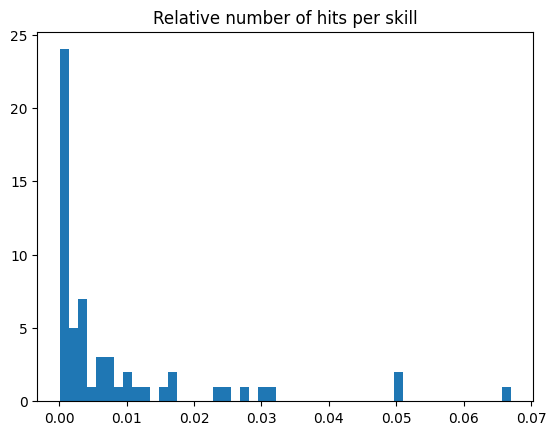

In [133]:
hit_ratios = np.array([len(np.unique(indices))/len(extracts) for indices in all_hit_indices.values()])
plt.hist(hit_ratios, bins=50)
plt.title("Relative number of hits per skill")
plt.show()

In [134]:
(hit_ratios<0.001).sum()

19

In [138]:
found_rules = np.array([set(nr for nr, indices in all_hit_indices.items() if index in indices) for index in range(len(extracts))])
found_statements = [{egp.iloc[nr-1]['Can-do statement'] for nr in rules} for rules in found_rules]
found_cats = [{egp.iloc[nr-1]['SubCategory'] for nr in rules} for rules in found_rules]
found_cat_level = [{f"{egp.iloc[nr-1]['SubCategory']}-{egp.iloc[nr-1]['Level']}" for nr in rules} for rules in found_rules]

num_rules = np.array([len(rules) for rules in found_rules])
num_cats = np.array([len(cats) for cats in found_cats])

In [148]:
list(zip(responses[np.where(num_cats>2)], np.array(found_statements)[num_cats>2]))

[("To be honest, I don't even have a driver's license myself, but I imagine I would take a taxi if it were available. I guess I could do a horse-drawn carriage and pretend I'm in an Austen novel :)",
  {"Can form conditional subordinate clauses with 'if' + past simple, and would in the main clause, to talk about an imagined situation, often in the context of advice or opinion-giving. ",
   "Can form negative statements of main verbs in the present simple with 'don't' + main verb. ► present simple ► can",
   "Can use 'would' in the main clause of a conditional sentence to talk about an imagined situation, often in the context of advice or opinion-giving.",
   "Can use 'would' with verbs such as 'advise', 'imagine', 'recommend', 'say' to be less direct.",
   'Can use the affirmative form.'}),
 ("Haha, I haven't heard of it either. But I would go see Silence of the Lambs again if they showed it on valentines day! Back in 1991 that came out and made 270 million haha! A Valetine's Day movie

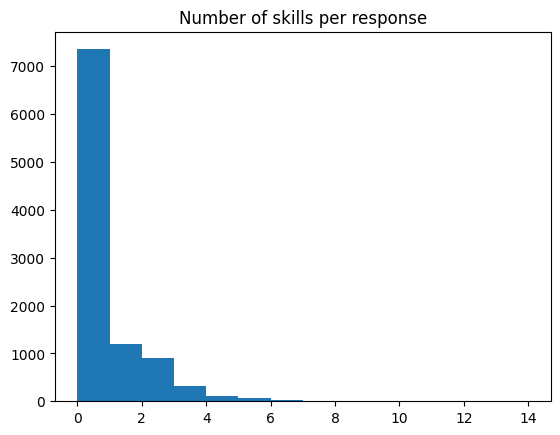

In [147]:
plt.hist(num_rules, bins=max(num_rules))
plt.title("Number of skills per response")
plt.show()

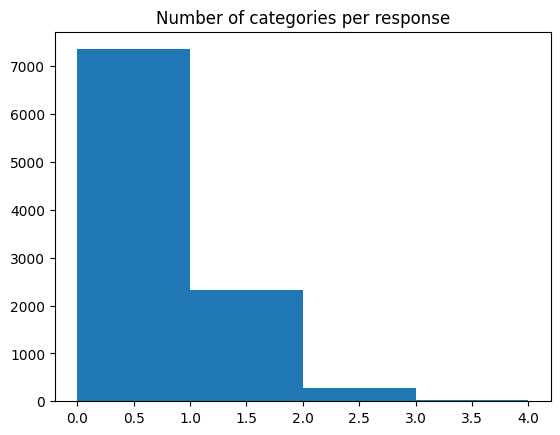

In [146]:

plt.hist(num_cats, bins=max(num_cats))
plt.title("Number of categories per response")
plt.show()

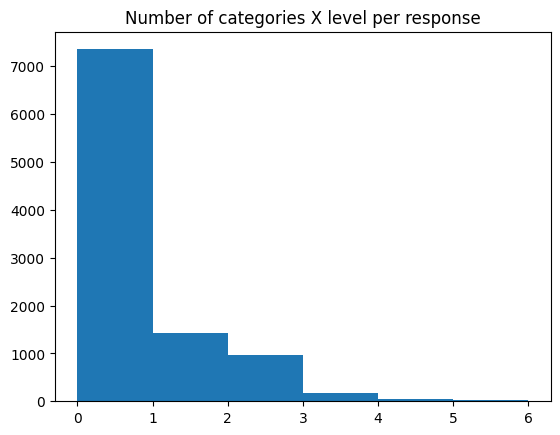

In [145]:
num_cat_levels = np.array([len(cats) for cats in found_cat_level])
plt.hist(num_cat_levels, bins=max(num_cat_levels))
plt.title("Number of categories X level per response")
plt.show()